In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

9395
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

In [12]:
# -----------------------------------------------------
# --- Canonical coordinate and some constants ---
# -----------------------------------------------------
xmax_, Nx_ = np.pi, 1001

x_ = np.linspace(-xmax_, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- Planck constant: h / 2pi, h = 6.6261e−34 J*s ---
hp_ = 1.0 

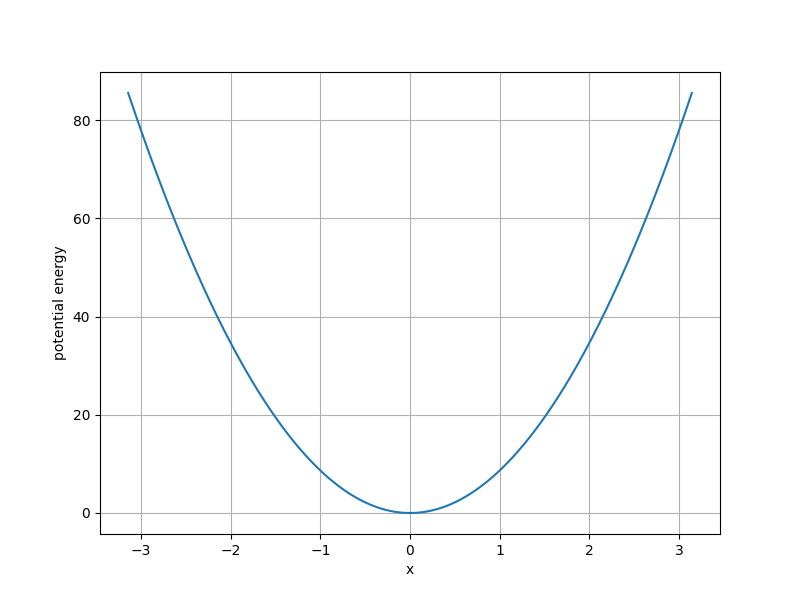

In [52]:
# -----------------------------------------------------
# --- Harmonic oscillator ---
# -----------------------------------------------------
def Rabi_model(x, dx, Nx, Ca, w, g, Delta):
    
    V = np.zeros(Nx) 

    coef0 = hp_**2 / (2.*Ca * dx**2)
    coef1 = 0.5 * Ca * w**2 

    V_func = lambda x: coef1 * x**2

    # --- Harmonic oscillator Haimltonian
    H = np.zeros((Nx, Nx))
    for ir in range(Nx):
        # --- Potential ---
        V[ir] = V_func(x[ir])

        # --- Hamiltonian ---
        if ir == 0:
            H[ir, Nx-1] = -coef0
        else:
            H[ir, ir-1] = -coef0

        if ir == (Nx-1):
            H[ir, 0] = -coef0
        else:
            H[ir, ir+1] = -coef0
        H[ir, ir] = 2. * coef0 + V[ir]

    # --- Interaction part ---
    coef2 = np.sqrt(w * Ca / (2. * hp_))
    Hi = np.diag(np.ones(Nx) * 2. * coef2 * g)

    # --- Rabi Hamiltonian ---
    NxD = 2*Nx
    Htot = np.zeros((NxD, NxD))

    H1 = np.ones(2*Nx) * Delta
    H1[Nx:NxD] *= -1.
    H1 = np.diag(H1)

    H2 = np.zeros((NxD, NxD))
    H2[0:Nx,0:Nx] = H
    H2[Nx:NxD, Nx:NxD] = H

    H3 = np.zeros((NxD, NxD))
    H3[0:Nx,Nx:NxD]  = Hi
    H3[Nx:NxD, 0:Nx] = Hi
    
    return H2, V, V_func, "rabi-model"
# ---------------------------------------------------------------
Ca_ = 1.2 # capacitance
w_  = 3.8 # frequency, 1/sqrt(LC)
g_ = 0.1
Delta_ = 0.1
H_, V_, V_func_, str_H_ = Rabi_model(x_, dx_, Nx_, Ca_, w_, g_, Delta_)

# mix.print_matrix(H_)

# --- Plot potential ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_, V_)
ax.set_xlabel("x")
ax.set_ylabel("potential energy")
ax.grid()
del ax, fig

In [53]:
# ------------------------------------------------------------
# --- Compute eigenvalues and eigenvectors ---
# ------------------------------------------------------------
def compute_eig(H):
    eigVals, eigVecs = np.linalg.eig(H)

    eigVals_sorted = np.sort(eigVals)
    ids_sort = np.argsort(eigVals)

    eigVecs_sorted = eigVecs[:,ids_sort]

    return eigVals_sorted, eigVecs_sorted
# ------------------------------------------------------------
def compute_anharmonicity(eigVals):
    Nx = len(eigVals)
    dw = np.zeros(Nx-1)
    for ix in range(Nx-1):
        dw[ix] = eigVals[ix+1] - eigVals[ix]

    anh = np.zeros(Nx-2)
    for ix in range(Nx-2):
        anh[ix] = dw[ix+1] - dw[ix]    
    return dw, anh
# ------------------------------------------------------------
eigVals_sorted_, eigVecs_sorted_ = compute_eig(H_)
dw_, anh_ = compute_anharmonicity(eigVals_sorted_)
print("Done")

Done


In [54]:
# ------------------------------------------------------------
# --- Print eigenvalues and anharmonicity ---
# ------------------------------------------------------------
def print_eigvals_via_diag_matrix(M, eigVecs_sorted, N_first_eigvals, ff_print):

    # --- matrix diagonalization ---
    Pinv = np.linalg.inv(eigVecs_sorted)
    M_diagonalized = np.dot(np.dot(Pinv, M), eigVecs_sorted)

    # --- extract elements on the main diagonal (eigenvalues) ---
    H_diag_diag = np.diag(M_diagonalized)

    # --- print several first diagonal elements ---
    mix.print_array(H_diag_diag[:N_first_eigvals], ff=ff_print, n_in_row = N_first_eigvals)
    return
# -------------------------------------------------------------------
Ne_print = 20
ff_print = [6, 3, "f"]

print("--- {:d} first eigenvalues ---".format(Ne_print))
mix.print_array(eigVals_sorted_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- {:d} first eigenvalues (via diagonalization) ---".format(Ne_print))
print_eigvals_via_diag_matrix(H_, eigVecs_sorted_, Ne_print, ff_print)

print("\n--- energy differences of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(dw_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- anharmonicity of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(anh_[:Ne_print], ff=[12, 3, "e"], n_in_row = Ne_print)

del Ne_print, ff_print

--- 20 first eigenvalues ---
 1.900  1.900  5.700  5.700  9.500  9.500 13.299 13.299 17.099 17.099 20.899 20.899 24.698 24.698 28.498 28.498 32.297 32.297 36.096 36.096 

--- 20 first eigenvalues (via diagonalization) ---
 1.900  1.900  5.700  5.700  9.500  9.500 13.299 13.299 17.099 17.099 20.899 20.899 24.698 24.698 28.498 28.498 32.297 32.297 36.096 36.096 

--- energy differences of first 20 eigenvalues ---
 0.000  3.800  0.000  3.800  0.000  3.800  0.000  3.800  0.000  3.800  0.000  3.799  0.000  3.799  0.000  3.799  0.000  3.799  0.000  3.799 

--- anharmonicity of first 20 eigenvalues ---
   3.800e+00   -3.800e+00    3.800e+00   -3.800e+00    3.800e+00   -3.800e+00    3.800e+00   -3.800e+00    3.800e+00   -3.800e+00    3.799e+00   -3.799e+00    3.799e+00   -3.799e+00    3.799e+00   -3.799e+00    3.799e+00   -3.799e+00    3.799e+00   -3.799e+00 


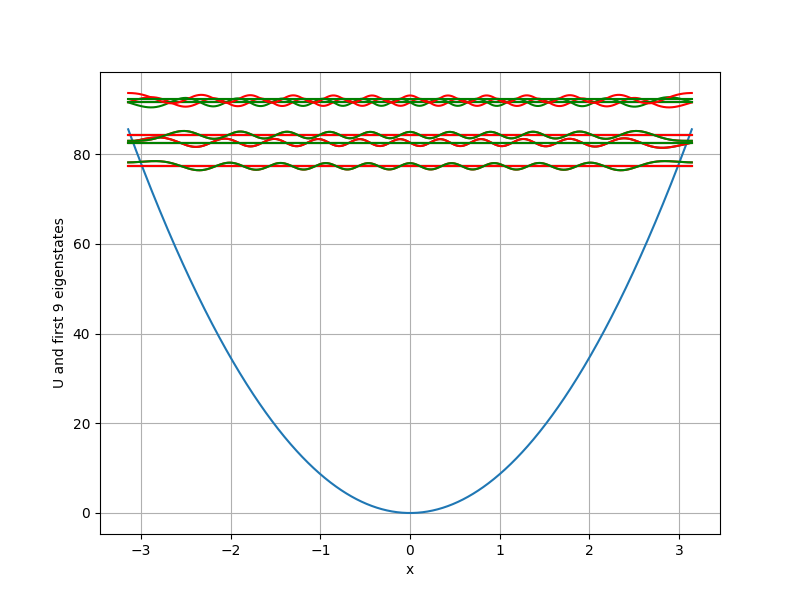

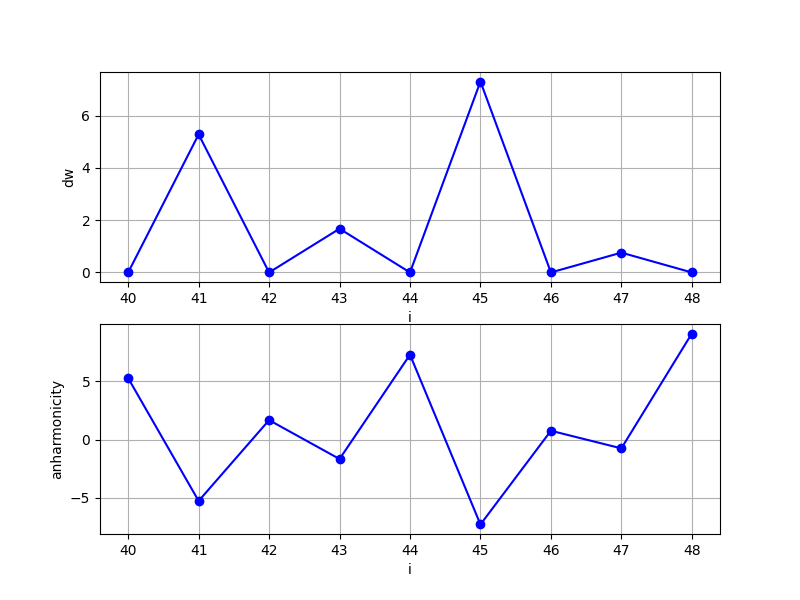

In [56]:
# ------------------------------------------------------------
# --- Plot eigenvalues, anharmonicity and eigenvectors ---
# ------------------------------------------------------------
def plot_eig_anh(id_eig_start, id_eig_end, resc_eigv = 4.0, flag_eigstates = True):
    N_eig = id_eig_end - id_eig_start

    # --- Plot eigenvalues and eigenstates ---
    if flag_eigstates:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(x_, V_, "-")
        for ii in range(id_eig_start, id_eig_end):
            ax.hlines(eigVals_sorted_[ii], -xmax_, xmax_, color="gray")

            eig_vec = resc_eigv * np.array(eigVecs_sorted_[:,ii]) 
            eig_vec += eigVals_sorted_[ii] * np.ones(2*Nx_)
            ax.plot(x_, eig_vec[:Nx_], "-", color="red")
            ax.plot(x_, eig_vec[Nx_:2*Nx_], "-", color="green")
        ax.set_xlabel("x")
        ax.set_ylabel("U and first {:d} eigenstates".format(N_eig))
        # ax.set_xlim([-coef_x_lim * x_curr, coef_x_lim * x_curr])
        # ax.set_ylim([-EJ_, eigVals_sorted_[N_eig+1]])
        ax.grid()

    # --- Plot energy-differences and anharomnicities ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(range(id_eig_start,id_eig_end), dw_[id_eig_start:id_eig_end], "-bo")
    ax.set_xlabel("i")
    ax.set_ylabel("dw")
    ax.grid()

    ax = fig.add_subplot(212)
    ax.plot(range(id_eig_start,id_eig_end), anh_[id_eig_start:id_eig_end], "-bo")
    ax.set_xlabel("i")
    ax.set_ylabel("anharmonicity")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    ax.grid()

    del N_eig
    return
# ----------------------------------------------------
plot_eig_anh(40, 49, resc_eigv = 20.0, flag_eigstates = True)

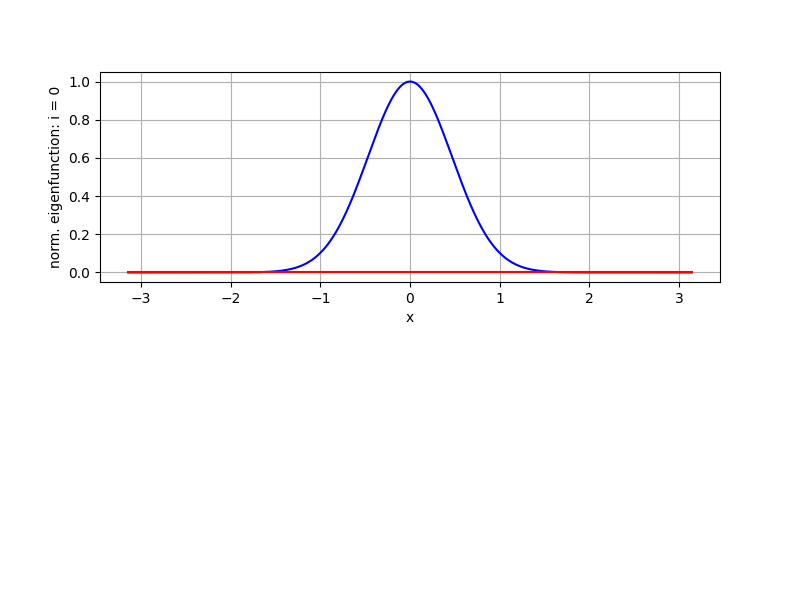

In [33]:
# ------------------------------------------------------------------
# --- Compare numerically computed and analytical eigenfunctions ---
# ------------------------------------------------------------------
import math
from scipy import special
def compare_eigfunction_with_analytics(id_to_plot):
    # # --- analytical function ---
    # coef_c = pow(Ca_ * w_/(np.pi * hp_), 0.25)
    # coef_pol = np.sqrt(Ca_ * w_ / hp_)
    # exp_func = np.exp(- Ca_ * w_ * x_**2/(2. * hp_))

    # coef1 = 1./ np.sqrt(2.**id_to_plot * math.factorial(id_to_plot))
    # He_pol = special.hermite(id_to_plot, monic=False)(coef_pol * x_)
    # eigf_a = coef_c * coef1 * exp_func * He_pol

    # eigf_a = eigf_a / np.max(np.abs(eigf_a))

    # --- num. function ---
    eigf_num = np.array(eigVecs_sorted_[:,id_to_plot])
    eigf_num /= np.max(np.abs(eigf_num))

    # # --- correct the sign ---
    # sign_func = 1.0
    # if(np.sum(eigf_num * eigf_a) < 0):
    #     sign_func = -1

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(x_, eigf_num[:Nx_], "-b")
    ax.plot(x_, eigf_num[Nx_:2*Nx_], "-r")
    # ax.plot(x_, sign_func * eigf_a,   "--r")
    ax.set_xlabel("x")
    ax.set_ylabel("norm. eigenfunction: i = {:d}".format(id_to_plot))
    ax.grid()

    # ax = fig.add_subplot(212)
    # ax.plot(x_, np.abs(eigf_num - sign_func * eigf_a), "-b")
    # ax.set_yscale('log')
    # ax.set_xlabel("x")
    # ax.set_ylabel("diff.")
    # ax.grid()
    return
# --------------------------------------------------------------------------
compare_eigfunction_with_analytics(id_to_plot = 0)